In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def load_and_clean_data(file_path):
    """
    Loads data from the Excel file, cleans it, and prepares it for analysis.
    """
    print("--- Starting Data Loading and Cleaning ---")

    try:
        df = pd.read_excel(file_path)
        print(f"Successfully loaded '{file_path}'.")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the Excel file: {e}")
        return None

    df = df.copy()

    # --- Clean and Transform Columns ---
    print("\nApplying transformations...")
    df.drop(columns=["Date", "Screentime"], errors='ignore', inplace=True)

    if 'Exercise' in df.columns:
        df['Exercise'] = df['Exercise'].astype(str).str.lower().apply(lambda x: 0 if x in ['no', '0', 'nan'] else 1)

    if 'Hydration' in df.columns:
        hydration_map = {"< 1L": 0.5, "1-2L": 1.5, "2+L": 2.5}
        df["Hydration"] = df["Hydration"].map(hydration_map)

    if 'Mood' in df.columns:
        df["Mood"] = df["Mood"].astype(str).str.strip()
        mood_map = {
            'Happy': 9, 'Relaxed': 8, 'Neutral': 5, 'Distracted': 4,
            'Tired': 3, 'Numb': 2, 'Unmotivated': 1, 'Sad': 2,
            'Hurt - Sad': 0, 'Anxious': 3, 'Overwhelmed': 2,
        }
        df['Mood_Encoded'] = df['Mood'].map(mood_map)
    else:
        print("Error: 'Mood' column not found.")
        return None

    # --- Handle Missing Values ---
    print("Handling missing values...")
    df.dropna(subset=['Mood_Encoded'], inplace=True)
    df['Mood_Encoded'] = df['Mood_Encoded'].astype(int)

    for col in ['Sleep', 'Study', 'Hydration', 'Exercise']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    for col in ['Sleep', 'Study', 'Hydration']:
        if col in df.columns and df[col].isnull().any():
            df[col] = df[col].interpolate().fillna(df[col].median())

    df.dropna(inplace=True)
    print("\n--- Data Cleaning Complete ---")
    return df

In [26]:
cleaned_df.describe()

,Sleep,Study,Exercise,Hydration,Mood_Encoded
count,121.000000,121.000000,121.000000,121.000000,121.000000
mean,7.369008,3.983471,0.297521,1.450413,4.132231
std,1.300815,2.328018,0.459068,0.217992,2.503139
min,5.000000,0.000000,0.000000,0.500000,0.000000
25%,6.083333,2.500000,0.000000,1.500000,2.000000
50%,7.500000,4.000000,0.000000,1.500000,3.000000
75%,8.000000,5.333333,1.000000,1.500000,5.000000
max,11.000000,10.000000,1.000000,1.500000,9.000000


In [27]:
cleaned_df.shape

(121, 7)

In [28]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121 entries, 0 to 149
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sleep          121 non-null    float64
 1   Study          121 non-null    float64
 2   Exercise       121 non-null    int64  
 3   Hydration      121 non-null    float64
 4   Mood           121 non-null    object 
 5   Mood_Encoded   121 non-null    int64  
 6   Mood_Category  121 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 7.6+ KB


In [33]:
def perform_eda(df):
    """
    Performs Exploratory Data Analysis (EDA) on the cleaned data with new plots.
    """
    print("\n\n--- Step 1: Exploratory Data Analysis (EDA) ---")

    # Create Mood Categories for clustering visualization
    def get_mood_category(score):
        if score <= 3:
            return 'Low Mood'
        elif score <= 6:
            return 'Neutral Mood'
        else:
            return 'High Mood'
    df['Mood_Category'] = df['Mood_Encoded'].apply(get_mood_category)

    # Plot 1: See how often you logged each mood
    plt.figure(figsize=(12, 7))
    sns.countplot(y=df['Mood'], order=df['Mood'].value_counts().index, palette='crest', hue=df['Mood'], legend=False)
    plt.title('How Often Was Each Mood Logged?', fontsize=20)
    plt.xlabel('Number of Days Logged', fontsize=16)
    plt.ylabel('Mood', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Get numeric columns for other plots
    numeric_cols = df.select_dtypes(include=np.number).drop(columns=['Mood_Encoded']).columns.tolist()

    # Plot 2: See how your habits are distributed
    if numeric_cols:
        df[numeric_cols].hist(bins=15, figsize=(15, 6), layout=(2, 3), color='skyblue')
        plt.suptitle('Distribution of Daily Habits', fontsize=20)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # Plot 3: See how sleep affects mood
    if 'Sleep' in df.columns:
        plt.figure(figsize=(12, 7))
        sns.boxplot(x='Sleep', y='Mood', data=df, palette='pastel', hue='Mood', legend=False, order=df.groupby('Mood')['Sleep'].median().sort_values().index)
        plt.title('How Does Sleep Duration Affect Mood?', fontsize=20)
        plt.xlabel('Sleep (hours)', fontsize=16)
        plt.ylabel('Mood', fontsize=16)
        plt.tight_layout()
        plt.show()

    # Plot 2: Correlation Heatmap
    plt.figure(figsize=(10, 8))
    # Including Mood_Encoded to see its correlation with habits
    corr_cols = df.select_dtypes(include=np.number).columns
    corr = df[corr_cols].corr()
    sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
    plt.title('Correlation Between Habits and Mood', fontsize=20)
    plt.tight_layout()
    plt.show()

    # Plot 3: Pairplot for Mood Clustering
    pairplot_cols = df.select_dtypes(include=np.number).columns.drop('Mood_Encoded').tolist()
    pairplot_cols.append('Mood_Category')
    print("\nGenerating pairplot to visualize mood clustering... (this may take a moment)")
    sns.pairplot(df[pairplot_cols], hue='Mood_Category', palette={'Low Mood': 'tomato', 'Neutral Mood': 'gold', 'High Mood': 'forestgreen'})
    plt.suptitle('Clustering of Moods Based on Habits', y=1.02, fontsize=16)
    plt.show()

--- Starting Data Loading and Cleaning ---
Successfully loaded '/content/mood tracker.xlsx'.

Applying transformations...
Handling missing values...

--- Data Cleaning Complete ---

Cleaned Data Head:
   Sleep  Study  Exercise  Hydration         Mood  Mood_Encoded
0  7.000    4.0         1        0.5  Unmotivated             1
1  7.000    4.0         1        0.5  Unmotivated             1
2  7.000    4.0         1        0.5  Unmotivated             1
3  7.000    4.0         1        0.5  Unmotivated             1
4  6.825    4.0         1        0.5  Unmotivated             1


--- Step 1: Exploratory Data Analysis (EDA) ---


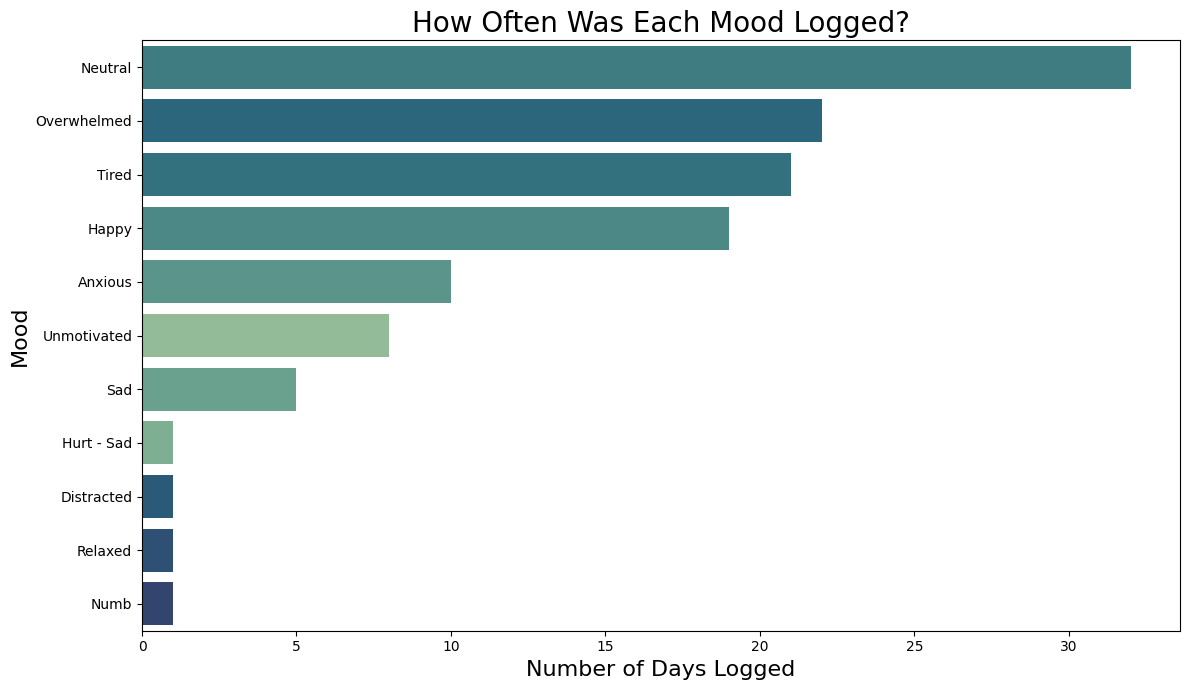

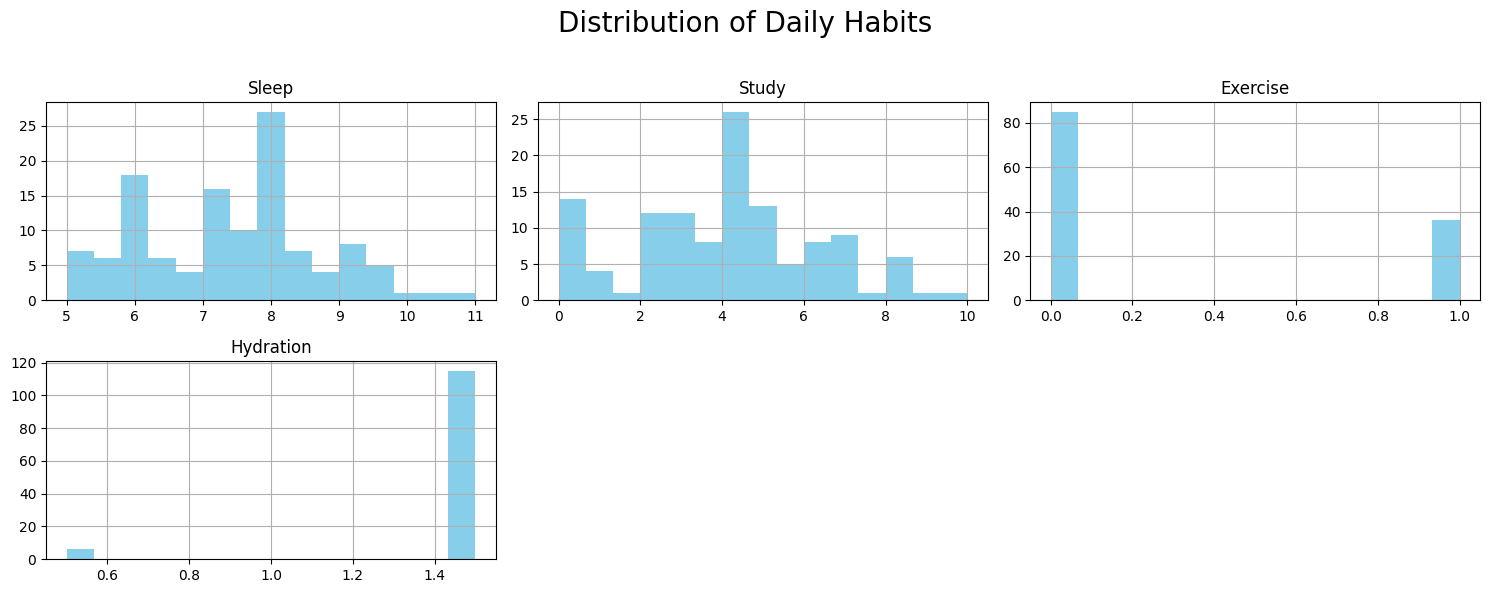

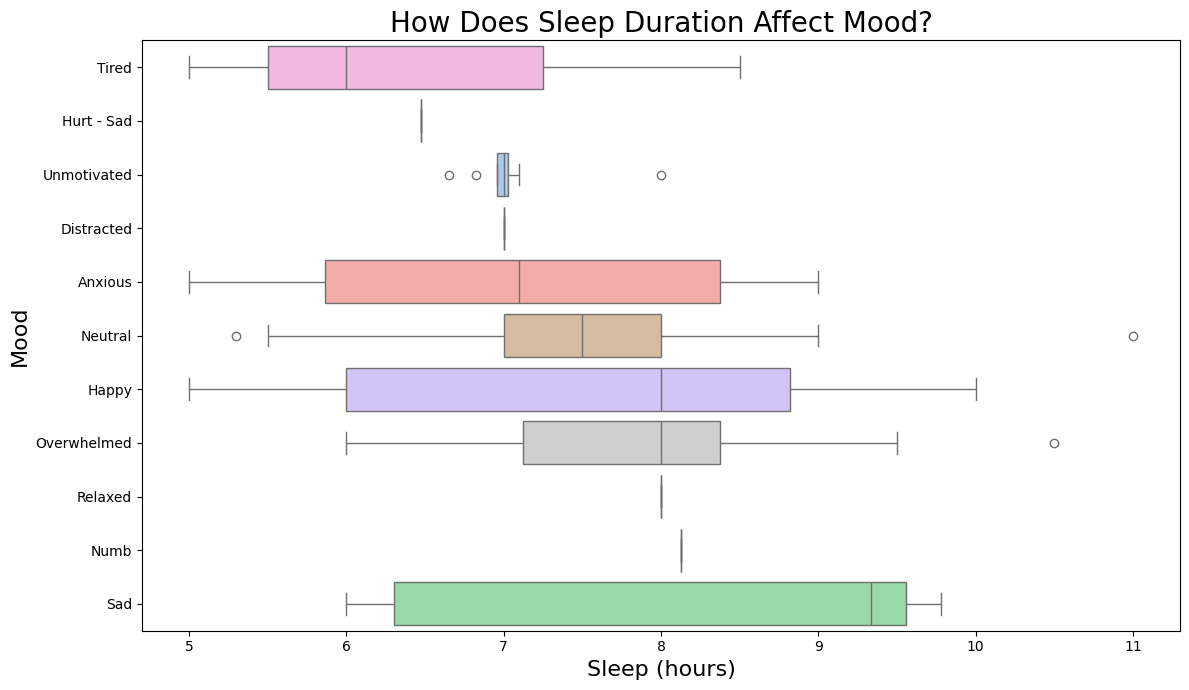

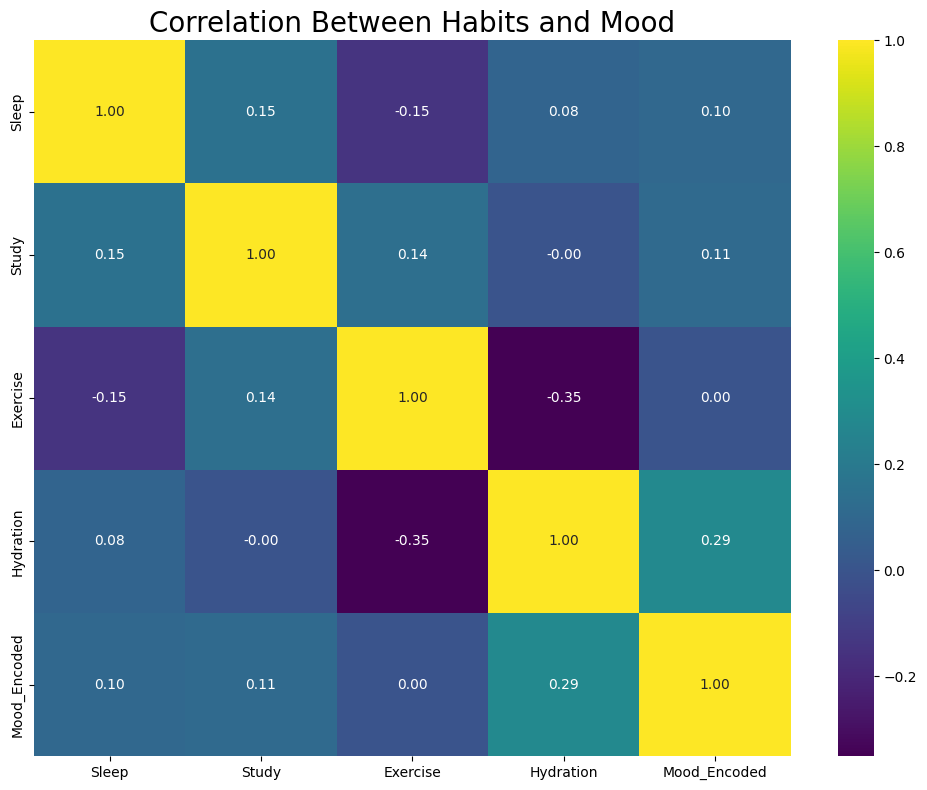


Generating pairplot to visualize mood clustering... (this may take a moment)


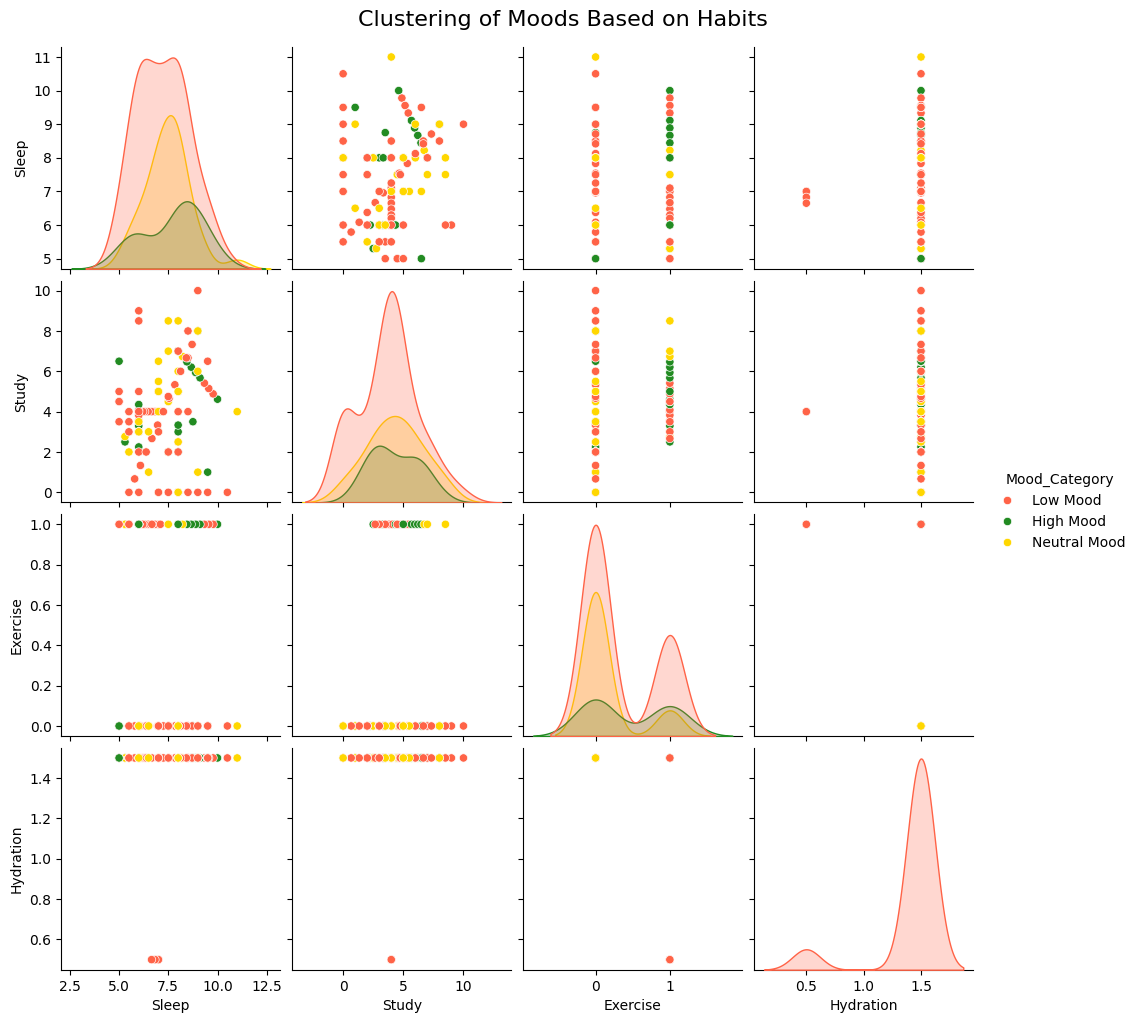



--- Step 2: Predictive Modeling ---
Features for training: ['Sleep', 'Study', 'Exercise', 'Hydration']
Model training complete.

--- Key Insights: Feature Importance ---
     feature  importance
0      Sleep    0.448821
1      Study    0.372719
2   Exercise    0.107180
3  Hydration    0.071280


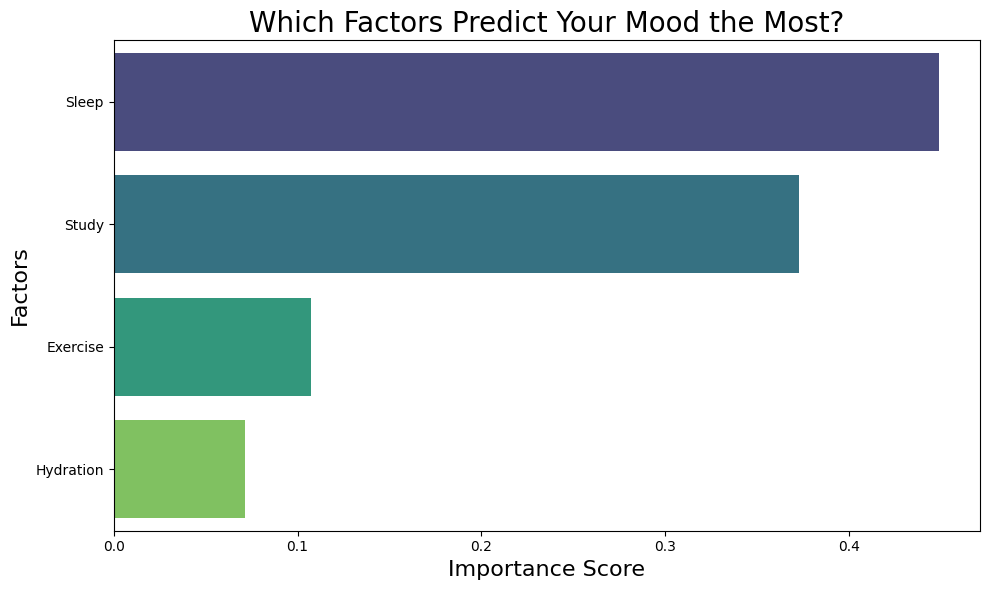

In [34]:
def train_and_evaluate_model(df):
    """
    Trains a model to find predictive patterns in the data.
    """
    print("\n\n--- Step 2: Predictive Modeling ---")

    X = df.drop(columns=['Mood', 'Mood_Encoded', 'Mood_Category']) # Drop new category column
    y = df['Mood_Encoded']

    if X.shape[1] == 0:
        print("Error: No feature columns left for training.")
        return

    print(f"Features for training: {X.columns.tolist()}")

    # Split Data
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    except ValueError:
        print("Warning: Could not stratify split (some moods may be rare). Using a standard split.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train Model
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    print("Model training complete.")

    # --- Feature Importance ---
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\n--- Key Insights: Feature Importance ---")
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, hue='feature', palette='viridis', legend=False)
    plt.title('Which Factors Predict Your Mood the Most?', fontsize=20)
    plt.xlabel('Importance Score', fontsize=16)
    plt.ylabel('Factors', fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    file_path = "/content/mood tracker.xlsx"

    cleaned_df = load_and_clean_data(file_path)

    if cleaned_df is not None and not cleaned_df.empty:
        print("\nCleaned Data Head:")
        print(cleaned_df.head())
        # First, explore the data visually
        perform_eda(cleaned_df)
        # Then, train a model to find predictive patterns
        train_and_evaluate_model(cleaned_df)
    else:
        print("\nAnalysis stopped because data could not be cleaned.")
